In [1]:
import matplotlib.pyplot as plt 
from scipy.io import readsav
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import colors
import cmasher as cmr
import sunpy.cm as cm #The functionality of the sunpy.cm module is now in sunpy.visualization.colormaps as of SunPy 1.1
from tqdm import tqdm
from helita.io import lp
import COCOpy as cp
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
import matplotlib as mpl
from scipy import ndimage
import COCOpy as cp
import time
import multiprocessing as mp

In [60]:
dpath_SST = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/'
dpath_SST_WB = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_wb/'
dpath_SST_processed = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/'
dpath_EDVARDA_SDO = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo2sst/' 
dpath_SDO_BOSE ='/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/SDO_only_aia/'
sdo_target_cubes = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo/target/cubes/'

# SST

In [61]:
# ---- Reduced H-beta data----
hdrH_im =lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
hdrH_sp = lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])

#----- Unsharp masked Dopplergram ----
hdr_dopp = lp.getheader(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_dopp = hdr_dopp[0]
cube_dopp = lp.getdata(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_dopp = np.reshape(cube_dopp,[dim_dopp[0],dim_dopp[1],dim_dopp[2]])

#------- RBE detections --------
hdr_rbe_mask = lp.getheader(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rbe_mask = hdr_rbe_mask[0]
cube_rbe_mask = lp.getdata(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rbe_mask = np.reshape(cube_rbe_mask,[dim_rbe_mask[0],dim_rbe_mask[1],dim_rbe_mask[2]])

#------ RRE detections --------
hdr_rre_mask = lp.getheader(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rre_mask = hdr_rre_mask[0]
cube_rre_mask = lp.getdata(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rre_mask = np.reshape(cube_rre_mask,[dim_rre_mask[0],dim_rre_mask[1],dim_rre_mask[2]])
#cube_dopp=np.swapaxes(cube_dopp,0,1)

#------ Fe I 6173 AA magnetic field------
hdr_mag_los = lp.getheader(dpath_SST+'Blos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_mag_los = hdr_mag_los[0]
cube_mag_los= lp.getdata(dpath_SST+'Blos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_mag_los = np.reshape(cube_mag_los, [dim_mag_los[0],dim_mag_los[1],dim_mag_los[2]])

#------ Fe I 6173 AA LOS velocity field------
hdr_V_los = lp.getheader(dpath_SST+'Vlos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_V_los = hdr_V_los[0]
cube_V_los= lp.getdata(dpath_SST+'Vlos_6173_09:56:56_aligned_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_V_los = np.reshape(cube_V_los, [dim_V_los[0],dim_V_los[1],dim_V_los[2]])

#------ H-beta 4861.33 AA line-core widths (see Line_widths.ipynb/.py for more details on this) ------
hdr_lc_widths = lp.getheader(dpath_SST+'lc_widths_nb_4846_2021-08-04T09:56:50_scans=0-95.fcube')
dim_lc_widths = hdr_lc_widths[0]
cube_lc_widths = lp.getdata(dpath_SST+'lc_widths_nb_4846_2021-08-04T09:56:50_scans=0-95.fcube')
cube_lc_widths = np.reshape(cube_lc_widths, [dim_lc_widths[0],dim_lc_widths[1],dim_lc_widths[2]])

#------ H-beta 4861.33 AA WB maps --------
hdr_wb = lp.getheader(dpath_SST_WB+'wb_4846_2021-08-04T09:56:50_scans=0-95_corrected_im.icube')
dim_wb = hdr_wb[0]
cube_wb = lp.getdata(dpath_SST_WB+'wb_4846_2021-08-04T09:56:50_scans=0-95_corrected_im.icube')
cube_wb = np.reshape(cube_wb,[dim_wb[0],dim_wb[1],dim_wb[2]])

#----- time and wavelength stamps --------
time_steps = readsav(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im_times+wvl.idlsave')
times = time_steps['times']
wav = time_steps['LAMBDA']

In [62]:
cube_wb.shape

(1796, 1138, 96)

In [22]:
H_avg = np.mean(np.mean(np.mean(cubeH[:,:,:,:],axis=0),axis=0),axis=0)

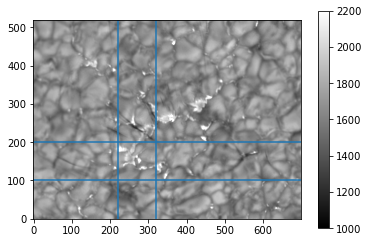

In [67]:
##------- Test display --------
plt.imshow(cubeH[400:1100,600:1120,77,20].T, origin='lower', cmap='gray',vmax=2200,vmin=1000)
plt.colorbar()
plt.axvline(x=220)
plt.axvline(x=320)
plt.axhline(y=100)
plt.axhline(y=200)

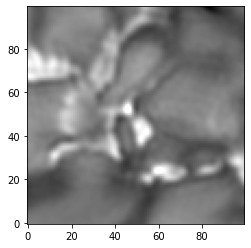

In [92]:
plt.imshow(cubeH[400+225:400+225+100,600+110:600+110+100,77,21].T, origin='lower', cmap='gray',vmax=2400,vmin=1400)

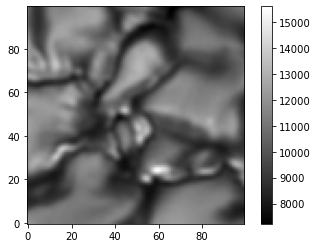

In [91]:
plt.imshow(cube_wb[400+225:400+225+100,600+110:600+110+100,77].T, origin='lower', cmap='gray')
plt.colorbar()
# plt.axvline(x=220)
# plt.axvline(x=320)
# plt.axhline(y=100)
# plt.axhline(y=200)

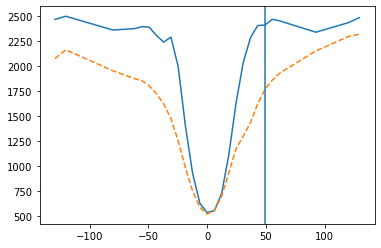

In [86]:
dopp_Hb = ((wav-wav[13])/wav[13])*3e5
plt.plot(dopp_Hb,cubeH[671,764,77,:])
plt.plot(dopp_Hb, H_avg, linestyle='dashed')
plt.axvline(dopp_Hb[21])

In [93]:
# Analysis for the plots

Wb_ROI = cube_wb[400+225:400+225+100,600+110:600+110+100,65:89] #ROI for the WB
H_beta_ROI = cubeH[400+225:400+225+100,600+110:600+110+100,65:89,21] #ROI for the WB
B_ROI = cube_mag_los[400+225:400+225+100,600+110:600+110+100,65:89]# ROI for B_los


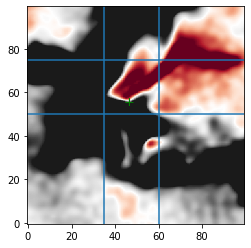

In [118]:
plt.imshow(B_ROI[:,:,12].T,origin='lower', vmin=-60, vmax=60, cmap='RdGy')
plt.text(44,54,'+', color='green',size=13)
plt.axvline(x=35)
plt.axvline(x=60)
plt.axhline(y=50)
plt.axhline(y=75)

Text(1.2040072000000002, 1.4776452, '+')

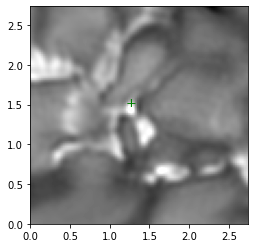

In [113]:
plt.imshow(H_beta_ROI[:,:,12].T, origin='lower',cmap='gray',vmax=2400,vmin=1400,extent=[0,100*0.0379*0.722,0,100*0.0379*0.722])
plt.text(44*0.0379*0.722,54*0.0379*0.722,'+', color='green',size=13)

In [128]:
neg_mag=np.zeros(24)
pos_mag = neg_mag*0
cancled_mag = neg_mag*0
for time in tqdm(range(24)):
    test_mag = B_ROI[35:60,50:75,time]
    mask = test_mag*0
    mask[np.where(test_mag <= -20)]=1.
    neg_mag[time] = np.sum(np.abs(test_mag*mask))*25*25*0.0379*722*1e5*0.0379*722*1e5  # Converting to Mx; 1 Mx = 1 Gcm^2
    pos_mag[time] = np.sum(np.abs(test_mag*(1-mask)))*25*25*0.0379*722*1e5*0.0379*722*1e5
    cancled_mag[time] = np.sum(np.abs(test_mag))*25*25*0.0379*722*1e5*0.0379*722*1e5


100%|██████████| 24/24 [00:00<00:00, 9165.37it/s]


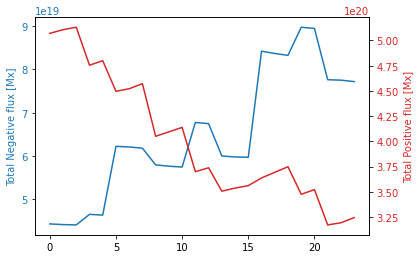

In [125]:
fig,ax= plt.subplots()
color = 'tab:blue'
ax.set_ylabel(r'Total Negative flux [Mx]',color=color)
#ax.set_xlabel(r'$\lambda$[nm]')
ax.plot(neg_mag,color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2=ax.twinx()
color ='tab:red'
ax2.set_ylabel(r'Total Positive flux [Mx]',color=color)
ax2.plot(pos_mag,color=color)
ax2.tick_params(axis='y', labelcolor=color)


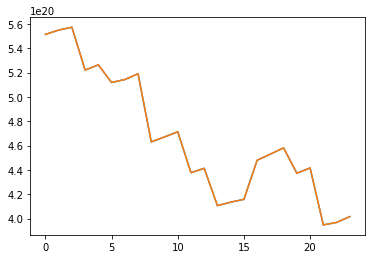

In [129]:
plt.plot(neg_mag+pos_mag)
plt.plot(cancled_mag)

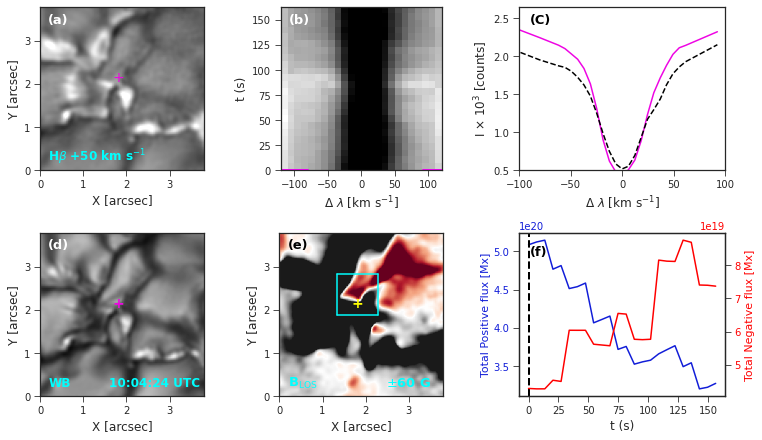

In [253]:
plt.style.use('seaborn-ticks')
point1 = [35*0.0379,50*0.0379]
point2 = [60*0.0379,50*0.0379]
point3 = [60*0.0379,75*0.0379]
point4 = [35*0.0379,75*0.0379]

x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]

x_values1 =[point3[0],point4[0]]
y_values1 =[point3[1],point4[1]]

x_values2 =[point1[0],point1[0]]
y_values2 =[point1[1],point3[1]]

x_values3 =[point2[0],point2[0]]
y_values3 =[point3[1],point2[1]]

for time in range(1):
    #time+=12
    axs = plt.figure(constrained_layout=True,figsize=(10.5,6)).subplot_mosaic(
    """
    ABC
    DEF
    """
    )
    axs["A"].imshow(H_beta_ROI[:,:,time].T, origin='lower',cmap='gray',vmax=2400,vmin=1400,extent=[0,100*0.0379,0,100*0.0379],aspect=1)
    axs["A"].text(44*0.0379,54*0.0379,'+', color='#ee05e3',size=14)
    axs["A"].set_yticks([0,1,2,3])
    axs["A"].set_ylabel('Y [arcsec]',size=12)
    axs["A"].set_xlabel('X [arcsec]',size=12)
    axs["A"].text(.05, .06, r'H$\beta$ +50 km s$^{-1}$', transform=axs["A"].transAxes, fontsize=12,color='cyan',weight='bold')
    axs["A"].text(0.05,.9, r'(a)', transform=axs["A"].transAxes, fontsize=13,color='white',weight='bold')
    
    axs["B"].imshow(cubeH[671,764,65:89,1:25],origin='lower',cmap='gray',interpolation='nearest',vmin=800,extent=[dopp_Hb[1],dopp_Hb[25],0,24*6.8],aspect=1.5)
    axs["B"].plot([dopp_Hb[1],dopp_Hb[2]],[time*6.8,time*6.8],color='#F603FE',linewidth=2)
    axs["B"].plot([dopp_Hb[24],dopp_Hb[25]],[time*6.8,time*6.8],color='#F603FE',linewidth=2)
    axs["B"].set_xlabel(r'$\Delta$ $\lambda$ [km s$^{-1}$]',size=12.)
    axs["B"].set_ylabel('t (s)',size=12.)
    axs["B"].text(0.05,.9, r'(b)', transform=axs["B"].transAxes, fontsize=13,color='white',weight='bold')
    
    axs["C"].plot(dopp_Hb[1:25],cubeH[671,764,65+time,1:25]/1e3,color='#ee05e3')
    axs["C"].plot(dopp_Hb[1:25],H_avg[1:25]/1e3,color='black',linestyle='dashed')
    axs["C"].set_ylim([500/1e3,2651/1e3])
    axs["C"].set_xlim([-100,100])
    axs["C"].set_ylabel(r'I $\times$ 10$^{3}$ [counts]',size=12)
    axs["C"].set_xlabel(r'$\Delta$ $\lambda$ [km s$^{-1}$]',size=12.)
    axs["C"].text(0.05,.9, r'(C)', transform=axs["C"].transAxes, fontsize=13,color='black',weight='bold')
    
    axs["D"].imshow(Wb_ROI[:,:,time].T,origin='lower',cmap='gray',vmin=7000,vmax=15000,extent=[0,100*0.0379,0,100*0.0379],aspect=1)
    axs["D"].text(44*0.0379,54*0.0379,'+', color='#ee05e3',size=14,weight='bold')
    axs["D"].set_yticks([0,1,2,3])
    axs["D"].set_ylabel('Y [arcsec]',size=12)
    axs["D"].set_xlabel('X [arcsec]',size=12)
    axs["D"].text(.05, .06, r'WB', transform=axs["D"].transAxes, fontsize=12,color='cyan',weight='bold')
    b = times[time+65][0:8]
    axs["D"].text(.7, .06, b.decode('utf-8')+' UTC',ha="center",color='cyan',size=12,transform=axs["D"].transAxes,weight='bold')
    axs["D"].text(0.05,.9, r'(d)', transform=axs["D"].transAxes, fontsize=13,color='white',weight='bold')
    
    axs["E"].imshow(B_ROI[:,:,time].T,origin='lower', vmin=-60, vmax=60, cmap='RdGy',extent=[0,100*0.0379,0,100*0.0379],aspect=1)
    axs["E"].text(44*0.0379,54*0.0379,'+', color='yellow',size=14,weight='bold')
    axs["E"].text(.05, .06, r'B$_{\mathrm{LOS}}$', transform=axs["E"].transAxes, fontsize=13,color='cyan',weight='bold')
    axs["E"].text(.65, .06, r'$\pm$60 G', transform=axs["E"].transAxes, fontsize=13,color='cyan',weight='bold')
    axs["E"].plot(x_values, y_values,color='cyan')
    axs["E"].plot(x_values1, y_values1,color='cyan')
    axs["E"].plot(x_values2, y_values2,color='cyan')
    axs["E"].plot(x_values3, y_values3,color='cyan')
    axs["E"].set_yticks([0,1,2,3])
    axs["E"].set_ylabel('Y [arcsec]',size=12)
    axs["E"].set_xlabel('X [arcsec]',size=12)
    axs["E"].text(0.05,.9, r'(e)', transform=axs["E"].transAxes, fontsize=13,color='black',weight='bold')

    axs["F"].plot(np.arange(24)*6.8,pos_mag, color='#111dd8')#'#d816c4')
    axs["F"].set_ylabel(r'Total Positive flux [Mx]',color='#111dd8',size=11)
    axs["F"].tick_params(axis='y', labelcolor='#111dd8')
    #axs["E"].set_xticklabels(labels =[time_str[0],time_str[20],time_str[40],time_str[60],time_str[80]])
    axs["F"].set_xticks([0,25,50,75,100,125,150])
    axs["F"].axvline(x=time*6.8,color='black',linewidth=2,linestyle='dashed')
    #axs["E"].axvspan(times[45], times[65],alpha=0.3, color ='gray')
    #axs["E"].set_xlabel('Time [UTC]')
    axs["F"].set_xlabel('t (s)',size=12.)
    axs["F"].text(0.05,.86, r'(f)', transform=axs["F"].transAxes, fontsize=13,color='black',weight='bold')
    
    ax2=axs["F"].twinx()
    color ='red'
    ax2.set_ylabel(r'Total Negative flux [Mx]',color=color,size=11)
    ax2.plot(np.arange(24)*6.8,neg_mag,color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    #plt.savefig('/mn/stornext/d9/souvikb/CBP_spicules_SDO/movies_FE_new/QSEB/QSEB_1-'+str(time)+'.png',dpi=300,bbox_inches = 'tight',pad_innches=0.1)
    plt.show()

